# ITD214 - Preparation, Modelling & Evaluation (Branded Bottoms)

This Colab notebook guides you through the **Python phase**: cleaning, EDA, modelling and evaluation using the `bottoms.csv` dataset.

Steps covered:
1. Setup & import libraries
2. Load and inspect data
3. Cleaning & encoding
4. Correlation check (Rating vs Price)
5. ANOVA / Tukey tests for Condition effect
6. OLS Linear Regression
7. Quantile Regression (Pricing Tiers)
8. Gradient-Boosted Trees (Benchmark)
9. Export tier thresholds for Tableau


In [1]:
# 1. Setup & Import Libraries
# Install packages if needed (uncomment)
!pip install statsmodels linearmodels scikit-learn shap

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from linearmodels.quantiles.model import QuantileRegression # Removed problematic import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

import shap
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.6 MB/s eta 0:00:00


In [2]:
# 2. Load and Inspect Data
df = pd.read_csv('bottoms_cleaned.csv', encoding='latin1', encoding_errors='ignore')
print(df.shape)
df.head()

(5198, 33)


,designer_names,condition,price,rating,follower_count,location,makeoffer,category,type,created_at,...,image_path,location_grouped,is_used,is_gently_used,is_new,is_worn,Other,United States,Canada,United Kingdom
0,Japanese Brand Ã Kapital Ã Mizra Jeans Kyoto,is_used,160,4.755556,57,Asia,True,bottoms,ListProduct,2025-05-15 13:37:31.298,...,kapital/bottoms/listproduct/a5680d5adf694ac889...,Other,1,0,0,0,1,0,0,0
1,Kapital Ã Number (N)ine Ã Vintage,is_gently_used,179,5.000000,70,Europe,True,bottoms,ListProduct,2025-05-14 17:16:20.980,...,kapital/bottoms/listproduct/a727e26491ee41659d...,Other,0,1,0,0,1,0,0,0
2,Kapital Ã Kapital Kountry,is_new,900,4.916667,31,United States,True,bottoms,ListProduct,2025-05-16 00:48:05.189,...,kapital/bottoms/listproduct/650d840e680943da91...,United States,0,0,1,0,0,1,0,0
3,Kapital,is_used,418,4.428571,16,Europe,True,bottoms,ListProduct,2025-05-15 19:07:50.641,...,kapital/bottoms/listproduct/6237eedf706d432095...,Other,1,0,0,0,1,0,0,0
4,Kapital,is_new,601,4.948478,6,Asia,True,bottoms,ListProduct,2025-05-16 20:04:46.704,...,kapital/bottoms/listproduct/f51b3ad8789543bcad...,Other,0,0,1,0,1,0,0,0


In [3]:
# 3. Basic Cleaning & Encoding
df = df[df['price'].notna() & (df['price'] > 0)]
cols = ['price', 'condition', 'rating', 'follower_count', 'location']
df = df[cols]
df = pd.get_dummies(df, columns=['condition', 'location'], drop_first=True)
df.head()

,price,rating,follower_count,condition_is_new,condition_is_used,condition_is_worn,location_Australia/NZ,location_Canada,location_Europe,location_Other,location_United Kingdom,location_United States
0,160,4.755556,57,False,True,False,False,False,False,False,False,False
1,179,5.000000,70,False,False,False,False,False,True,False,False,False
2,900,4.916667,31,True,False,False,False,False,False,False,False,True
3,418,4.428571,16,False,True,False,False,False,True,False,False,False
4,601,4.948478,6,True,False,False,False,False,False,False,False,False


Correlation between rating and price: 0.106


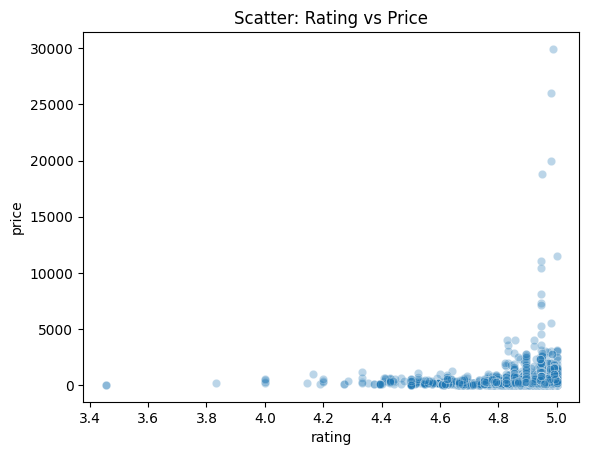

In [4]:
# 4. Correlation Check: Rating vs Price
corr = df['rating'].corr(df['price'])
print(f"Correlation between rating and price: {corr:.3f}")
sns.scatterplot(data=df, x="rating", y="price", alpha=0.3)
plt.title("Scatter: Rating vs Price")
plt.show()

In [5]:
# 5. ANOVA / Tukey Test for Condition
df_anova = pd.read_csv('bottoms_cleaned.csv', encoding='latin1', encoding_errors='ignore')
df_anova = df_anova[df_anova['price'].notna() & (df_anova['price'] > 0)]
anova_results = sm.stats.anova_lm(
    smf.ols('price ~ C(condition)', data=df_anova).fit(), typ=2
)
print(anova_results)

tukey = pairwise_tukeyhsd(endog=df_anova['price'],
                          groups=df_anova['condition'],
                          alpha=0.05)
print(tukey)

                    sum_sq      df          F        PR(>F)
C(condition)  1.992998e+08     3.0  99.943833  6.792069e-63
Residual      3.452484e+09  5194.0        NaN           NaN
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1      group2  meandiff p-adj    lower     upper   reject
------------------------------------------------------------------
is_gently_used  is_new  360.9472    0.0  282.0004   439.894   True
is_gently_used is_used -185.7283    0.0 -252.1602 -119.2964   True
is_gently_used is_worn -216.5077  0.016 -404.0512  -28.9642   True
        is_new is_used -546.6756    0.0 -629.2197 -464.1314   True
        is_new is_worn -577.4549    0.0 -771.2923 -383.6176   True
       is_used is_worn  -30.7794 0.9754 -219.8654  158.3066  False
------------------------------------------------------------------


In [8]:
# Formula regression (add predictors as needed)
# Rename columns to remove spaces and special characters for formula
df_renamed = df.rename(columns=lambda x: x.replace(' ', '_').replace('/', '_').replace('-', '_'))

formula_terms = ["rating", "follower_count"] + [c for c in df_renamed.columns if c.startswith("condition_") or c.startswith("location_")]
ols_formula = "price ~ " + " + ".join(formula_terms)

ols_model = smf.ols(ols_formula, data=df_renamed).fit()

print(ols_model.summary())

# Nested model comparison: with vs. without condition
base_formula_terms = ["rating", "follower_count"] + [c for c in df_renamed.columns if c.startswith("location_")]
base_formula = "price ~ " + " + ".join(base_formula_terms)

base_model = smf.ols(base_formula, data=df_renamed).fit()
anova_compare = anova_lm(base_model, ols_model)
print(anova_compare)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     54.78
Date:                Mon, 18 Aug 2025   Prob (F-statistic):          2.76e-115
Time:                        12:28:31   Log-Likelihood:                -42079.
No. Observations:                5198   AIC:                         8.418e+04
Df Residuals:                    5186   BIC:                         8.426e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [10]:
# 6. OLS Linear Regression
# Rename columns to remove spaces and special characters for formula
df_renamed = df.rename(columns=lambda x: x.replace(' ', '_').replace('/', '_').replace('-', '_'))

formula_terms = ["rating", "follower_count"] + [c for c in df_renamed.columns if c.startswith("condition_") or c.startswith("location_")]
ols_formula = "price ~ " + " + ".join(formula_terms)

ols_model = smf.ols(ols_formula, data=df_renamed).fit()
print(ols_model.summary())

base_formula_terms = ["rating", "follower_count"] + [c for c in df_renamed.columns if c.startswith("location_")]
base_formula = "price ~ " + " + ".join(base_formula_terms)

base_model = smf.ols(base_formula, data=df_renamed).fit()
anova_compare = anova_lm(base_model, ols_model)
print(anova_compare)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     54.78
Date:                Mon, 18 Aug 2025   Prob (F-statistic):          2.76e-115
Time:                        12:29:54   Log-Likelihood:                -42079.
No. Observations:                5198   AIC:                         8.418e+04
Df Residuals:                    5186   BIC:                         8.426e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [13]:
# 7. Quantile Regression (Pricing Tiers)
from statsmodels.regression.quantile_regression import QuantReg

quantiles = [0.25, 0.5, 0.75]
y = df['price']
X = df.drop(columns=['price'])
X = sm.add_constant(X)

# Convert boolean columns to integers
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

for q in quantiles:
    mod = QuantReg(y, X)
    res = mod.fit(q=q, max_iter=5000) # Increased max_iter
    print(f"\nQuantile {q}")
    print(res.summary())


Quantile 0.25
                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.1716
Model:                       QuantReg   Bandwidth:                       51.16
Method:                 Least Squares   Sparsity:                        230.4
Date:                Mon, 18 Aug 2025   No. Observations:                 5198
Time:                        12:34:37   Df Residuals:                     5186
                                        Df Model:                           11
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -18.9870     53.483     -0.355      0.723    -123.836      85.862
rating                     40.7937     10.898      3.743      0.000      19.428      62.159
follower_count              0.7989      0.037     21.455      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


MAE: 220.9701853965051
RMSE: 531.9462278273971
R^2: -0.12136529380505845


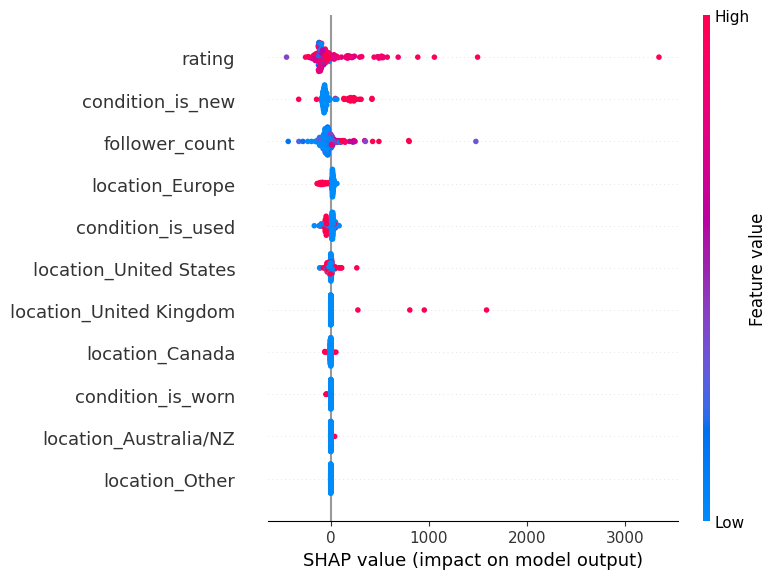

In [14]:
# 8. Gradient-Boosted Trees (Accuracy Benchmark)
X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
gbr = HistGradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2:", r2_score(y_test, y_pred))

# Convert boolean columns to integers for SHAP
for col in X_train.columns:
    if X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)
for col in X_test.columns:
    if X_test[col].dtype == 'bool':
        X_test[col] = X_test[col].astype(int)


explainer = shap.Explainer(gbr, X_train)
shap_values = explainer(X_test[:200], check_additivity=False) # Disable additivity check
shap.summary_plot(shap_values, X_test[:200])

In [15]:
# 9. Export Tier Thresholds for Tableau
df_tiers = df_anova.groupby("condition")["price"].quantile([0.25, 0.5, 0.75]).unstack()
df_tiers.columns = ["Q1", "Median", "Q3"]
print(df_tiers)
df_tiers.to_csv("condition_price_tiers.csv")

                    Q1  Median     Q3
condition                            
is_gently_used   99.00   250.0  494.0
is_new          355.00   584.0  901.0
is_used          70.00   150.0  188.0
is_worn         138.75   160.0  165.0
